# Lab 04: Image Matching and Image Stitching

In this lab, you'll implement and play with the algorithms taught in course 5 and 6. 

- Student Name: 万晨阳
- Student ID: 3210105327
- Date: 2023-11-7

---

## Part I: Image Matching

### Task 1: Find corners with harris detector

In [4]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

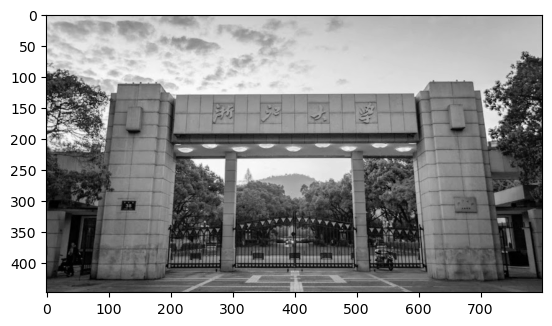

In [5]:
# Let's load an example image
filename = 'building.jpeg'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
fig = plt.imshow(img, cmap='gray')

Step 1. Compute the covariance matrix at each point

$$H=\sum_{(u,v)}w(u,v)\begin{bmatrix}I_x^2& I_xI_y\\I_xI_y &I_y^2\end{bmatrix}$$

where $I_x=\frac{\partial f}{\partial x}, I_y=\frac{\partial f}{\partial y}$, $\sum_{(u,v)}w(u,v)$ means gaussian at each map .


In [6]:
# normalize image to [0,1]
img = img.astype(np.float32) / 255.0

# use sobel operator at every location
Ix = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
Iy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
mat = np.array([Ix**2, Ix*Iy, Ix*Iy, Iy**2])

# gaussian weights, what window-size should be used?
window_size = 5
sigmaX = 10
sigmaY= 10

# compute H 
H = np.array([cv2.GaussianBlur(mat[i], (window_size, window_size), sigmaX=sigmaX, sigmaY=sigmaY) for i in range(4)])
H = H.reshape((2,2,img.shape[0],img.shape[1]))


Step 2. Harris response

Theoretically, we can compute eigenvalues

$H=\begin{bmatrix}a&b\\c&d\end{bmatrix}\quad \lambda_\pm=\frac{1}{2}((a+d)\pm\sqrt{4bc+(a-d)^2})$

and then classify points using eigenvalues of H, like:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/harris_region.jpg" alt="drawing" width="200"/>

However, computing eigenvalues are expensive, so we use the following alternative:

$$f=\frac{\lambda_1 \lambda_2}{\lambda_1+\lambda_2}=\frac{determinant(H)}{trace(H)}$$

where $det(\begin{bmatrix}a&b\\c&d\end{bmatrix})=ad-bc$,   and $trace(\begin{bmatrix}a&b\\c&d\end{bmatrix})=a+d$

In [7]:
# compute harris response
f = (H[0,0] * H[1,1] - H[0,1] * H[1,0]) / (H[0,0] + H[1,1] + 1e-6)

Step 3. Threshold $f$ and visualize

we skip non-maximum suppression operation here. You only need to visualize the thresholded harris response map.

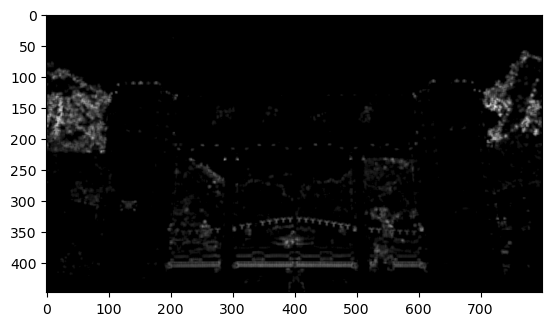

In [8]:
# threshold and visualize the response map
threshold = 0.05
thresholded = f.copy()
# thresholded = np.ones(f.shape)
thresholded[f < threshold] = 0
fig = plt.imshow(thresholded, cmap='gray')

Further reading:

[【计算机视觉】2. 特征点检测：Harris, SIFT, SURF, ORB](https://zhuanlan.zhihu.com/p/36382429)

### Task 2: SIFT

To do this task, read [opencv documentation on SIFT](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html) first, and use it for local feature detection and description.

In [9]:
# load an image
img0 = cv2.imread("1.jpeg", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("2.jpeg", cv2.IMREAD_GRAYSCALE)

In [10]:
# creat sift extractor (detector + descriptor)
SIFT = cv2.SIFT_create()

# get the detector and descriptor
kpts0, descs0 = SIFT.detectAndCompute(img0, None)
kpts1, descs1 = SIFT.detectAndCompute(img1, None)

For SIFT descriptors, people usually match them with ratio-test.

(1) Please list the main advantage of ratio-test in matching SIFT descriptors.

(2) Do you think mutual-nearest-neighbor method can also work?

Answers:

 (1) The Ratio Test helps in reducing false matches by considering the ratio of the distances between the best and second-best matching descriptors. By comparing the best distance to the second-best distance, the Ratio Test provides a measure of the confidence in the match. If the ratio is close to 1, it indicates that the match is not very distinctive and may be unreliable, allowing for the rejection of such matches. This helps in increasing the robustness of SIFT feature matching, especially in situations where there might be noise, scale changes, or ambiguities in the image.
 
 (2) Yes, the mutual-nearest-neighbor method can also work effectively for feature matching. It enforces bidirectional consistency by requiring that a pair of feature descriptors are each other's nearest neighbors. The mutual-nearest-neighbor method can increase the discriminative power and reduce the false positives. It's an good alternative approach to reduce false matches and improve the robustness of feature matching.

In [11]:
# compute descriptor distance
def calc_descs_dist(descs1, descs2):
    """
    Args:
        descs1: (N1, 128) descriptors
        descs2: (N2, 128) descriptors
    Return:
        dist: (N1, N2) distance matrix
    """
    num_of_descs1 = descs1.shape[0]
    num_of_descs2 = descs2.shape[0]

    for i in range(num_of_descs1):
        index_of_max = np.argmax(descs1[i])
        descs1[i] = np.roll(descs1[i], -index_of_max)
    for i in range(num_of_descs2):
        index_of_max = np.argmax(descs2[i])
        descs2[i] = np.roll(descs2[i], -index_of_max)

    dist = np.zeros((num_of_descs1, num_of_descs2))
    for i in range(num_of_descs1):
        for j in range(num_of_descs2):
            dist[i, j] = np.linalg.norm(descs1[i] - descs2[j])
    return dist

# ratio test
def ratio_test(kpts1, kpts2, dist):
    """
    Args:
        kpts1: (N1, 2) keypoints
        kpts2: (N2, 2) keypoints
        dist: (N1, N2) distance matrix
    Return:
        mkpts1: (N, 2) keypoints
        mkpts2: (N, 2) keypoints
    """
    if len(kpts1) != dist.shape[0] or len(kpts2) != dist.shape[1]:
        raise ValueError("kpts and dist do not match")
    r = 0.25

    mkpts1 = []
    mkpts2 = []

    for i in range(dist.shape[0]):
        best = np.min(dist[i])
        second_best = np.sort(dist[i])[1]
        if best / second_best < r:
            mkpts1.append(kpts1[i].pt)
            mkpts2.append(kpts2[np.argmin(dist[i])].pt)
    return np.array(mkpts1), np.array(mkpts2)

def MNN_test(kpts1, kpts2, dist):
    """
    Args:
        kpts1: (N1, 2) keypoints
        kpts2: (N2, 2) keypoints
        dist: (N1, N2) distance matrix
    Return:
        mkpts1: (N, 2) keypoints
        mkpts2: (N, 2) keypoints
    """
    if len(kpts1) != dist.shape[0] or len(kpts2) != dist.shape[1]:
        raise ValueError("kpts and dist do not match")

    mkpts1 = []
    mkpts2 = []
    matches12 = np.zeros((dist.shape[0], dist.shape[1]))
    matches21 = np.ones((dist.shape[0], dist.shape[1]))

    for i in range(dist.shape[0]):
        matches12[i, np.argmin(dist[i])] = 2

    for j in range(dist.shape[1]):
        matches21[np.argmin(dist[:, j]), j] = 2
    
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            if matches12[i, j] == matches21[i, j]:
                mkpts1.append(kpts1[i].pt)
                mkpts2.append(kpts2[j].pt)

    return np.array(mkpts1), np.array(mkpts2)


distance = calc_descs_dist(descs0, descs1)
mkpts0, mkpts1 = ratio_test(kpts0, kpts1, distance)
# mkpts0, mkpts1 = MNN_test(kpts0, kpts1, distance)


And visualize the final matches.

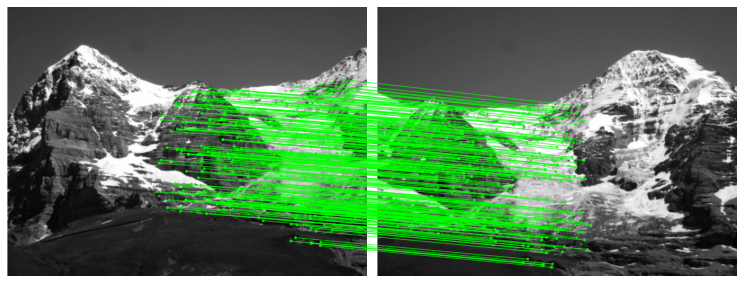

In [12]:
# visualization
from utils import make_matching_figure
fig = make_matching_figure(img0, img1, mkpts0, mkpts1) # You might need to read the documentation of this function. Or you can write your own drawing function.
# fig

---

## Part II: Image Stitching

One application fo image matching is to stitch multiple images and get one panorama.

### Task 3: Transformation

Considering 2 images as input, you can use SIFT (provided by cv2) to find the transformation between them (implement it on your own).

In [13]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# load images
# img0_rgb = cv2.imread("1.jpeg", cv2.IMREAD_COLOR)[..., [2,1,0]]
# img1_rgb = cv2.imread("2.jpeg", cv2.IMREAD_COLOR)[..., [2,1,0]]
img0_rgb = cv2.imread("2.bmp", cv2.IMREAD_COLOR)
img1_rgb = cv2.imread("1.bmp", cv2.IMREAD_COLOR)
img0_gray = cv2.cvtColor(img0_rgb, cv2.COLOR_RGB2GRAY)
img1_gray = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)

In [24]:
# compute SIFT keypoints and descriptors
# note: on gray image
SIFT = cv2.SIFT_create()

# get the detector and descriptor
kpts0, descs0 = SIFT.detectAndCompute(img0_gray, mask=np.ones_like(img0_gray, dtype=np.uint8))
kpts1, descs1 = SIFT.detectAndCompute(img1_gray, mask=np.ones_like(img1_gray, dtype=np.uint8))

distance = calc_descs_dist(descs0, descs1)
mkpts0, mkpts1 = ratio_test(kpts0, kpts1, distance)
# mkpts0, mkpts1 = MNN_test(kpts0, kpts1, distance)

Here, the transformation $H$ is defined as 
$$\begin{bmatrix}x_0\\y_0\\1\end{bmatrix}=\begin{bmatrix}h_{11}&h_{12}&h_{13}\\h_{21}&h_{22}&h_{23}\\0&0&1\end{bmatrix}\begin{bmatrix}x_1\\y_1\\1\end{bmatrix}$$

Please answer:

(1) What type is this transformation?

(2) Please write down the converted equation in the form of $Ah=b$. To solve this equation, what's the minimal number of matches that we need? 

Answers:

(1) Affine transformation.

(2) The converted equation in the form of $Ah=b$ is:

$$
\begin{bmatrix}
x_{10} & y_{10} & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_{10} & y_{10} & 1 \\
x_{20} & y_{20} & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_{20} & y_{20} & 1 \\
x_{30} & y_{30} & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_{30} & y_{30} & 1 \\
\end{bmatrix} 
\begin{bmatrix}
h_{11} \\
h_{12} \\
h_{13} \\
h_{21} \\
h_{22} \\
h_{23} \\
\end{bmatrix}
=
\begin{bmatrix}
x_{11} \\
y_{11} \\
x_{21} \\
y_{21} \\
x_{31} \\
y_{31} \\
\end{bmatrix}  
$$

where $(x_{i0}, y_{i0})$ is the coordinate of the point in the first image, and $(x_{i1}, y_{i1})$ is the coordinate of the matched point in the second image. The minimal number of matches that we need is 3.

In [25]:
# randomly select K matches (according to your answer)
shuffled_idx = np.arange(mkpts0.shape[0])
np.random.shuffle(shuffled_idx)
idx = shuffled_idx[:3]
selected_mkpts0 = mkpts0[idx]
selected_mkpts1 = mkpts1[idx]

def get_equation(selected_mkpts0, selected_mkpts1):
    """
    Args:
        selected_mkpts0: (K, 2)
        selected_mkpts1: (K, 2)
    Returns:
        A: (7, 7)
    """

    A = np.zeros((7,7))
    for i in range(3):
        A[2*i] = [selected_mkpts0[i][0], selected_mkpts0[i][1], 1, 0, 0, 0, -selected_mkpts1[i][0]]
        A[2*i+1] = [0, 0, 0, selected_mkpts0[i][0], selected_mkpts0[i][1], 1, -selected_mkpts1[i][1]]
    A[6] = [0, 0, 0, 0, 0, 0, 1]
    foo = np.eye(7) * 1e-6
    A += foo
    return A

# solve the equation with np.linalg.solve(A,0)
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
A = get_equation(selected_mkpts0, selected_mkpts1)
h = np.linalg.solve(A, np.append(np.zeros(6), [1]))
h = np.append(h[:6], [0, 0, 1]).reshape(3, 3)
print(h)


[[ 1.05608979e+00 -4.37089557e-02 -1.48670429e+03]
 [ 1.94026638e-02  1.00055361e+00 -3.95247556e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Task 4: RANSAC

To use naive ransac algorithm, we need $N$ sample-points(样本点), to solve the model, we need $K$ sample-points as a minimal requirement. Then perform:

1. Randomly sample $K$ sample-points.
2. Fit the model with $K$ sample-points. Denoted as $\hat h$.
3. Compute error of other sample points according to $\hat h$. Count the inliers within some threshold.
4. Repeat $M$ times, the final $h$ is the $\hat h$ with most inliers. 

In [26]:
def get_complement(len_samples, idx):
    """
    Args:
        len_samples: length of samples
        idx: (K)
    Returns:
        complement_idx: (len_samples - K)
    """
    mask = np.ones(shape=(len_samples), dtype=bool)
    mask[idx] = False
    return np.arange(len_samples, dtype=int)[mask]

def fit(mkpts0, mkpts1, idx):
    """
    Args:
        mkpts0: (N, 2)
        mkpts1: (N, 2)
        idx: (K)
    Returns:
        h: (3, 3)
    """
    selected_mkpts0 = mkpts0[idx]
    selected_mkpts1 = mkpts1[idx]
    A = np.zeros((7,7))
    for i in range(3):
        A[2*i] = [selected_mkpts0[i][0], selected_mkpts0[i][1], 1, 0, 0, 0, -selected_mkpts1[i][0]]
        A[2*i+1] = [0, 0, 0, selected_mkpts0[i][0], selected_mkpts0[i][1], 1, -selected_mkpts1[i][1]]
    A[6] = [0, 0, 0, 0, 0, 0, 1]

    foo = np.eye(7) * 1e-6
    A += foo
    h = np.linalg.solve(A, np.append(np.zeros(6), [1]))
    h = np.append(h[:6], [0, 0, 1]).reshape(3, 3)
    return h

    
def evaluate(h_hat, mkpts0, mkpts1, inlier_thr, idx):
    """
    Args:
        h_hat: (3, 3)
        mkpts0: (N, 2)
        mkpts1: (N, 2)
        inlier_thr: scalar
        idx: (K)
    Returns:
        inlier_count: scalar
    """
    ones_line = np.ones(shape=(len(idx), 1))
    v0 = np.concatenate((mkpts0[idx], ones_line), axis=1).T
    v1 = np.concatenate((mkpts1[idx], ones_line), axis=1).T
    fit = np.linalg.norm(v0 - h_hat @ v1, axis=0) 
    return np.count_nonzero(fit < inlier_thr)

# implement your own RANSAC
def ransac_to_estimate_H(samples, K, inlier_thr, M):
    """
    Args:
        samples: (2, N, 2)
        K: number of samples
        inlier_thr: scalar
        M: number of iterations
    Returns:
        best_h_hat: (3, 3)
    """
    mkpts1, mkpts0 = samples
    shuffled_idx = np.arange(mkpts0.shape[0])
    best_h_hat = np.array([])
    best_inlier_count = 0

    for i in range(M):
        np.random.shuffle(shuffled_idx)
        sample_idx = shuffled_idx[:K]
        # print(sample_idx)
        complement_idx = get_complement(samples[0].shape[0], sample_idx)
        # print(complement_idx)
        h_hat = fit(mkpts0, mkpts1, sample_idx)
        inlier_count = evaluate(h_hat, mkpts0, mkpts1, inlier_thr, complement_idx)
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            print("best inlier count update: ", best_inlier_count)
            best_h_hat = h_hat
    
    return best_h_hat

samples = np.array([mkpts0, mkpts1])
H = ransac_to_estimate_H(samples, 3, 3000, 1000)
print(H)

best inlier count update:  103
[[ 9.09921027e-01  9.28630676e-02  1.40182406e+03]
 [-2.29864005e-02  1.00717557e+00  8.33784485e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


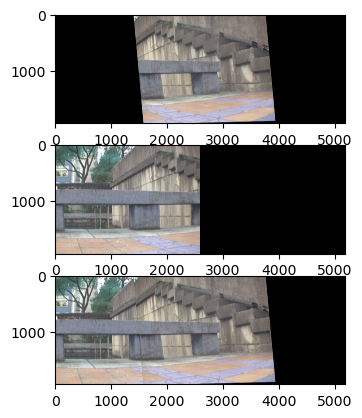

In [27]:
# use cv2.warpPerspective to put one image on the other
dsize = np.array([img1_rgb.shape[1]*2, img1_rgb.shape[0]])
pano = cv2.warpPerspective(src=img1_rgb.copy(), M=H, dsize=dsize, dst=img0_rgb.copy(), flags=cv2.INTER_LINEAR)
plt.subplot(311).imshow(pano)

res = np.zeros(shape=(dsize[1], dsize[0], 3), dtype=np.uint8)
res[:, :img1_rgb.shape[1], :] = img0_rgb
plt.subplot(312).imshow(res)

mask = np.zeros_like(res, dtype=bool)
mask[ pano > 0 ] = True
res[mask] = pano[mask]
plt.subplot(313).imshow(res)
# visualize the results


How to solve the artifacts in the overlapping region? Name 2 possible methods.

Answers:

1. Feathering or blurring is a common technique used to reduce artifacts in the overlapping region. This method involves smoothly transitioning pixel values from one image to another, which helps to create a seamless blend.
2. After stitching, consider additional post-processing steps, such as color correction and contrast adjustments, to further enhance the appearance of the stitched image and make seams less noticeable.